(analysis-framework-tutorial)=
# Tutorial 3. Building custom analyses - the data analysis framework

```{seealso}

The complete source code of this tutorial can be found in

{nb-download}`Tutorial 3. Building custom analyses - the data analysis framework.ipynb`

```

Quantify provides an analysis framework in the form of a {class}`~quantify_core.analysis.base_analysis.BaseAnalysis` class and several subclasses for simple cases (e.g., {class}`~quantify_core.analysis.base_analysis.BasicAnalysis`, {class}`~quantify_core.analysis.base_analysis.Basic2DAnalysis`, {class}`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis`). The framework provides a structured, yet flexible, flow of the analysis steps. We encourage all users to adopt the framework by sub-classing the {class}`~quantify_core.analysis.base_analysis.BaseAnalysis`.

To give insight into the concepts and ideas behind the analysis framework, we first write analysis scripts to *"manually"* analyze the data as if we had a new type of experiment in our hands.
Next, we encapsulate these steps into reusable functions packing everything together into a simple python class.

We conclude by showing how the same class is implemented much more easily by extending the {class}`~quantify_core.analysis.base_analysis.BaseAnalysis` and making use of the quantify framework.

In [1]:
import json
import logging
from pathlib import Path
from typing import Tuple

import lmfit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.analysis.cosine_analysis import CosineAnalysis
from quantify_core.analysis.fitting_models import CosineModel, cos_func
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)
from quantify_core.measurement import MeasurementControl
from quantify_core.utilities.examples_support import mk_cosine_instrument
from quantify_core.utilities.inspect_utils import display_source_code
from quantify_core.visualization.SI_utilities import set_xlabel, set_ylabel

Before instantiating any instruments or starting a measurement we change the
directory in which the experiments are saved using the
{meth}`~quantify_core.data.handling.set_datadir`
\[{meth}`~quantify_core.data.handling.get_datadir`\] functions.

----------------------------------------------------------------------------------------

⚠️ **Warning!**

We recommend always setting the directory at the start of the python kernel and stick
to a single common data directory for all notebooks/experiments within your
measurement setup/PC.

The cell below sets a default data directory (`~/quantify-data` on Linux/macOS or
`$env:USERPROFILE\\quantify-data` on Windows) for tutorial purposes. Change it to your
desired data directory. The utilities to find/search/extract data only work if
all the experiment containers are located within the same directory.

----------------------------------------------------------------------------------------

In [2]:
set_datadir('D:\HW\量子元件實驗室\Qblox\Qblox_datadir')  # change me!

## Run an experiment

We mock an experiment in order to generate a toy dataset to use in this tutorial.

In [3]:
display_source_code(mk_cosine_instrument)

def mk_cosine_instrument() -> Instrument:
    """A container of parameters (mock instrument) providing a cosine model."""

    instr = Instrument("ParameterHolder")

    # ManualParameter's is a handy class that preserves the QCoDeS' Parameter
    # structure without necessarily having a connection to the physical world
    instr.add_parameter(
        "amp",
        initial_value=0.5,
        unit="V",
        label="Amplitude",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "freq",
        initial_value=1,
        unit="Hz",
        label="Frequency",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "t", initial_value=1, unit="s", label="Time", parameter_class=ManualParameter
    )
    instr.add_parameter(
        "phi",
        initial_value=0,
        unit="Rad",
        label="Phase",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "noise_level",
        initial_value=0.05,
        unit="V",
        label="Noise level",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "acq_delay", initial_value=0.02, unit="s", parameter_class=ManualParameter
    )

    def cosine_model():
        sleep(instr.acq_delay())  # simulates the acquisition delay of an instrument
        return (
            cos_func(instr.t(), instr.freq(), instr.amp(), phase=instr.phi(), offset=0)
            + np.random.randn() * instr.noise_level()
        )

    # Wrap our function in a Parameter to be able to associate metadata to it, e.g. unit
    instr.add_parameter(
        name="sig", label="Signal level", unit="V", get_cmd=cosine_model
    )

    return instr

In [4]:
meas_ctrl = MeasurementControl("meas_ctrl")
plotmon = pqm.PlotMonitor_pyqt("plotmon")
meas_ctrl.instr_plotmon(plotmon.name)
pars = mk_cosine_instrument()

meas_ctrl.settables(pars.t)
meas_ctrl.setpoints(np.linspace(0, 2, 30))
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("Cosine experiment")

Starting iterative measurement...
100% completed | elapsed time:      1s | time left:      0s  
100% completed | elapsed time:      1s | time left:      0s  

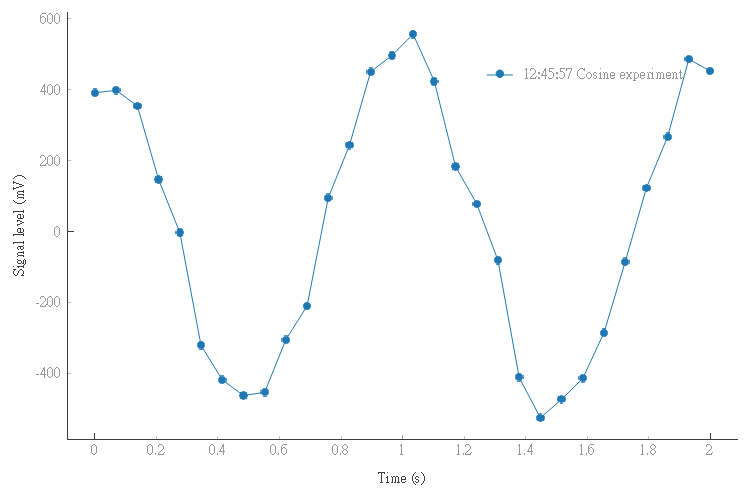

In [5]:
plotmon.main_QtPlot

## Manual analysis steps

### Loading the data

The {class}`~xarray.Dataset` contains all the information required to perform a basic analysis of the experiment.
We can alternatively load the dataset from disk based on its {class}`~quantify_core.data.types.TUID`, a timestamp-based unique identifier. If you do not know the tuid of the experiment you can find the latest tuid containing a certain string in the experiment name using {meth}`~quantify_core.data.handling.get_latest_tuid`.
See the {ref}`data-storage` documentation for more details on the folder structure and files contained in the data directory.

In [6]:
tuid = get_latest_tuid(contains="Cosine experiment")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset>
Dimensions:  (dim_0: 30)
Coordinates:
    x0       (dim_0) float64 0.0 0.06897 0.1379 0.2069 ... 1.793 1.862 1.931 2.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.3917 0.3988 0.3542 ... 0.2678 0.4867 0.4531
Attributes:
    tuid:                             20231121-124557-902-bdea39
    name:                             Cosine experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

### Performing a fit

We have a sinusoidal signal in the experiment dataset, the goal is to find the underlying parameters.
We extract these parameters by performing a fit to a model, a cosine function in this case.
For fitting we recommend using the lmfit library. See [the lmfit documentation](https://lmfit.github.io/lmfit-py/model.html) on how to fit data to a custom model.

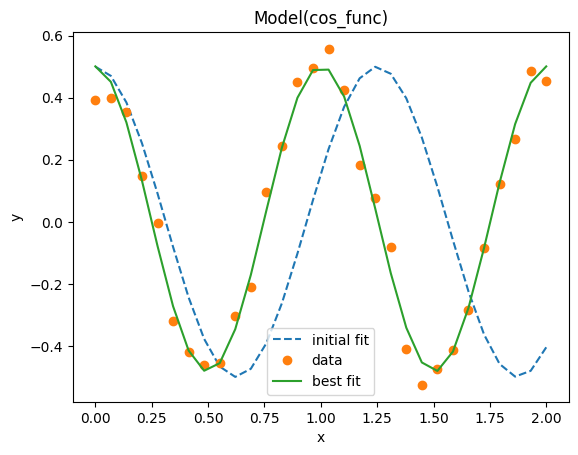

In [7]:
# create a fitting model based on a cosine function
fitting_model = lmfit.Model(cos_func)

# specify initial guesses for each parameter
fitting_model.set_param_hint("amplitude", value=0.5, min=0.1, max=2, vary=True)
fitting_model.set_param_hint("frequency", value=0.8, vary=True)
fitting_model.set_param_hint("phase", value=0)
fitting_model.set_param_hint("offset", value=0)
params = fitting_model.make_params()

# here we run the fit
fit_result = fitting_model.fit(dataset.y0.values, x=dataset.x0.values, params=params)

# It is possible to get a quick visualization of our fit using a build-in method of lmfit
_ = fit_result.plot_fit(show_init=True)

The summary of the fit result can be nicely printed in a Jupyter-like notebook:

In [8]:
fit_result

### Analyzing the fit result and saving key quantities

In [9]:
quantities_of_interest = {
 "amplitude": fit_result.params["amplitude"].value,
 "frequency": fit_result.params["frequency"].value,
}
quantities_of_interest

{'amplitude': 0.4917787054789595, 'frequency': 0.9950657434539957}

Now that we have the relevant quantities, we want to store them in the same
`experiment directory` where the raw dataset is stored.

First, we determine the experiment directory on the file system.

In [10]:
# the experiment folder is retrieved with a convenience function
exp_folder = Path(locate_experiment_container(dataset.tuid))
exp_folder

WindowsPath('D:/HW/量子元件實驗室/Qblox/Qblox_datadir/20231121/20231121-124557-902-bdea39-Cosine experiment')

Then, we save the quantities of interest to disk in the human-readable JSON format.

In [11]:
with open(exp_folder / "quantities_of_interest.json", "w", encoding="utf-8") as file:
    json.dump(quantities_of_interest, file)

### Plotting and saving figures

We would like to save a plot of our data and the fit in our lab logbook but the figure above is not fully satisfactory: there are no units and no reference to the original dataset.

Below we create our own plot for full control over the appearance and we store it on disk in the same `experiment directory`.
For plotting, we use the ubiquitous matplotlib and some visualization utilities.

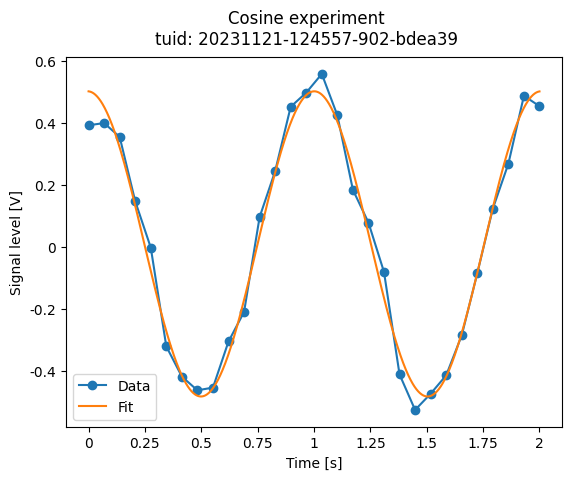

In [12]:
# create matplotlib figure
fig, ax = plt.subplots()

# plot data
dataset.y0.plot.line(ax=ax, x="x0", marker="o", label="Data")

# plot fit
x_fit = np.linspace(dataset["x0"][0], dataset["x0"][-1], 1000)
y_fit = cos_func(x=x_fit, **fit_result.best_values)
ax.plot(x_fit, y_fit, label="Fit")
ax.legend()

# set units-aware tick labels
set_xlabel(dataset.x0.long_name, dataset.x0.units)
set_ylabel(dataset.y0.long_name, dataset.y0.units)

# add a reference to the origal dataset in the figure title
fig.suptitle(f"{dataset.attrs['name']}\ntuid: {dataset.attrs['tuid']}")

# Save figure
fig.savefig(exp_folder / "Cosine fit.png", dpi=300, bbox_inches="tight")

## Reusable fitting model and analysis steps

The previous steps achieve our goal, however, the code above is not easily reusable and hard to maintain or debug.
We can do better than this! We can package our code in functions that perform specific tasks.
In addition, we will use the objected-oriented interface of `lmfit` to further structure our code.
We explore the details of the object-oriented approach later in this tutorial.

In [13]:
class MyCosineModel(lmfit.model.Model):
    """
    `lmfit` model with a guess for a cosine fit.
    """

    def __init__(self, *args, **kwargs):
        """Configures the constraints of the model."""
        # pass in the model's equation
        super().__init__(cos_func, *args, **kwargs)

        # configure constraints that are independent from the data to be fitted

        self.set_param_hint("frequency", min=0, vary=True)  # enforce positive frequency
        self.set_param_hint("amplitude", min=0, vary=True)  # enforce positive amplitude
        self.set_param_hint("offset", vary=True)
        self.set_param_hint(
            "phase", vary=True, min=-np.pi, max=np.pi
        )  # enforce phase range

    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        """Guess parameters based on the data."""

        self.set_param_hint("offset", value=np.average(data))
        self.set_param_hint("amplitude", value=(np.max(data) - np.min(data)) / 2)
        # a simple educated guess based on experiment type
        # a more elaborate but general approach is to use a Fourier transform
        self.set_param_hint("frequency", value=1.2)

        params_ = self.make_params()
        return lmfit.models.update_param_vals(params_, self.prefix, **kws)

Most of the code related to the fitting model is now packed in a single object, while the analysis steps are split into functions that take care of specific tasks.

In [14]:
def extract_data(label: str) -> xr.Dataset:
    """Loads a dataset from its label."""
    tuid_ = get_latest_tuid(contains=label)
    dataset_ = load_dataset(tuid_)
    return dataset_

def run_fitting(dataset_: xr.Dataset) -> lmfit.model.ModelResult:
    """Executes fitting."""
    model = MyCosineModel()  # create the fitting model
    params_guess = model.guess(data=dataset_.y0.values)
    result = model.fit(
        data=dataset_.y0.values, x=dataset_.x0.values, params=params_guess
    )
    return result

def analyze_fit_results(fit_result_: lmfit.model.ModelResult) -> dict:
    """Analyzes the fit results and saves quantities of interest."""
    quantities = {
        "amplitude": fit_result_.params["amplitude"].value,
        "frequency": fit_result_.params["frequency"].value,
    }
    return quantities

def plot_fit(
    fig_: matplotlib.figure.Figure,
    ax_: matplotlib.axes.Axes,
    dataset_: xr.Dataset,
    fit_result_: lmfit.model.ModelResult,
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plots a fit result."""
    dataset_.y0.plot.line(ax=ax_, x="x0", marker="o", label="Data")  # plot data

    x_fit_ = np.linspace(dataset_["x0"][0], dataset_["x0"][-1], 1000)
    y_fit_ = cos_func(x=x_fit_, **fit_result_.best_values)
    ax_.plot(x_fit, y_fit_, label="Fit")  # plot fit
    ax_.legend()

    # set units-aware tick labels
    set_xlabel(dataset_.x0.long_name, dataset_.x0.units, ax_)
    set_ylabel(dataset_.y0.long_name, dataset_.y0.units, ax_)

    # add a reference to the original dataset_ in the figure title
    fig_.suptitle(f"{dataset_.attrs['name']}\ntuid: {dataset_.attrs['tuid']}")

def save_quantities_of_interest(tuid_: str, quantities_of_interest_: dict) -> None:
    """Saves the quantities of interest to disk in JSON format."""
    exp_folder_ = Path(locate_experiment_container(tuid_))
    # Save fit results
    with open(exp_folder_ / "quantities_of_interest.json", "w", encoding="utf-8") as f_:
        json.dump(quantities_of_interest_, f_)

def save_mpl_figure(tuid_: str, fig_: matplotlib.figure.Figure) -> None:
    """Saves a matplotlib figure as PNG."""
    exp_folder_ = Path(locate_experiment_container(tuid_))
    fig_.savefig(exp_folder_ / "Cosine fit.png", dpi=300, bbox_inches="tight")
    plt.close(fig_)

Now the execution of the entire analysis becomes much more readable and clean:

In [15]:
dataset = extract_data(label="Cosine experiment")
fit_result = run_fitting(dataset)
quantities_of_interest = analyze_fit_results(fit_result)
save_quantities_of_interest(dataset.tuid, quantities_of_interest)
fig, ax = plt.subplots()
plot_fit(fig_=fig, ax_=ax, dataset_=dataset, fit_result_=fit_result)
save_mpl_figure(dataset.tuid, fig)

If we inspect the experiment directory, we will find a structure that looks like the following:

```{code-block}
20230125-172712-018-87b9bf-Cosine experiment/
├── Cosine fit.png
├── dataset.hdf5
├── quantities_of_interest.json
└── snapshot.json
```

## Creating a simple analysis class

Even though we have improved code structure greatly, in order to execute the same analysis against some other dataset we would have to copy-paste a significant portion of code (the analysis steps).

We tackle this by taking advantage of the Object Oriented Programming (OOP) in python.
We will create a python class that serves as a structured container for data (attributes) and the methods (functions) that act on the information.

Some of the advantages of OOP are:

- the same class can be instantiated multiple times to act on different data while reusing the same methods;
- all the methods have access to all the data (attributes) associated with a particular instance of the class;
- subclasses can inherit from other classes and extend their functionalities.

Let's now observe what such a class could look like.

```{warning}
This analysis class is intended for educational purposes only.
It is not intended to be used as a template!
See the end of the tutorial for the recommended usage of the analysis framework.
```

In [16]:
class MyCosineAnalysis:
    """Analysis as a class."""

    def __init__(self, label: str):
        """This is a special method that python calls when an instance of this class is
        created."""

        self.label = label

        # objects to be filled up later when running the analysis
        self.tuid = None
        self.dataset = None
        self.fit_results = {}
        self.quantities_of_interest = {}
        self.figs_mpl = {}
        self.axs_mpl = {}

    # with just slight modification our functions become methods
    # with the advantage that we have access to all the necessary information from self
    def run(self):
        """Execute the analysis steps."""
        self.extract_data()
        self.run_fitting()
        self.analyze_fit_results()
        self.create_figures()
        self.save_quantities_of_interest()
        self.save_figures()

    def extract_data(self):
        """Load data from disk."""
        self.tuid = get_latest_tuid(contains=self.label)
        self.dataset = load_dataset(tuid)

    def run_fitting(self):
        """Fits the model to the data."""
        model = MyCosineModel()
        guess = model.guess(self.dataset.y0.values)
        result = model.fit(
            self.dataset.y0.values, x=self.dataset.x0.values, params=guess
        )
        self.fit_results.update({"cosine": result})

    def analyze_fit_results(self):
        """Analyzes the fit results and saves quantities of interest."""
        self.quantities_of_interest.update(
            {
                "amplitude": self.fit_results["cosine"].params["amplitude"].value,
                "frequency": self.fit_results["cosine"].params["frequency"].value,
            }
        )

    def save_quantities_of_interest(self):
        """Save quantities of interest to disk."""
        exp_folder_ = Path(locate_experiment_container(self.tuid))
        with open(
            exp_folder_ / "quantities_of_interest.json", "w", encoding="utf-8"
        ) as file_:
            json.dump(self.quantities_of_interest, file_)

    def plot_fit(self, fig_: matplotlib.figure.Figure, ax_: matplotlib.axes.Axes):
        """Plot the fit result."""

        self.dataset.y0.plot.line(ax=ax_, x="x0", marker="o", label="Data")  # plot data

        x_fit_ = np.linspace(self.dataset["x0"][0], self.dataset["x0"][-1], 1000)
        y_fit_ = cos_func(x=x_fit_, **self.fit_results["cosine"].best_values)
        ax_.plot(x_fit_, y_fit_, label="Fit")  # plot fit
        ax_.legend()

        # set units-aware tick labels
        set_xlabel(self.dataset.x0.long_name, self.dataset.x0.attrs["units"], ax_)
        set_ylabel(self.dataset.y0.long_name, self.dataset.y0.attrs["units"], ax_)

        # add a reference to the original dataset in the figure title
        fig_.suptitle(f"{dataset.attrs['name']}\ntuid: {dataset.attrs['tuid']}")

    def create_figures(self):
        """Create figures."""
        fig_, ax_ = plt.subplots()
        self.plot_fit(fig_, ax_)

        fig_id = "cos-data-and-fit"
        self.figs_mpl.update({fig_id: fig_})
        # keep a reference to `ax` as well
        # it can be accessed later to apply modifications (e.g., in a notebook)
        self.axs_mpl.update({fig_id: ax_})

    def save_figures(self):
        """Save figures to disk."""
        exp_folder_ = Path(locate_experiment_container(self.tuid))
        for fig_name, fig_ in self.figs_mpl.items():
            fig_.savefig(exp_folder_ / f"{fig_name}.png", dpi=300, bbox_inches="tight")
            plt.close(fig_)

Running the analysis is now as simple as:

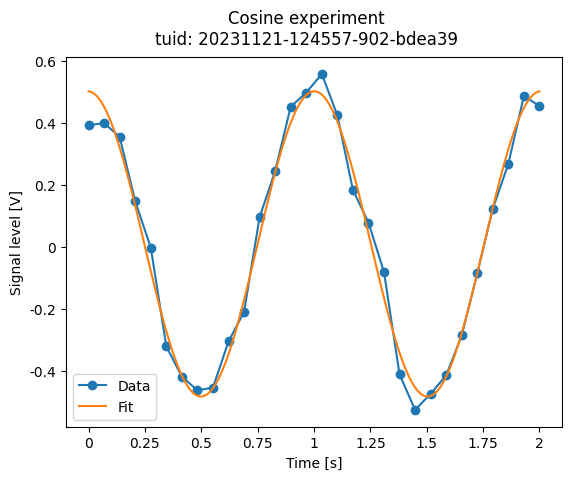

In [17]:
a_obj = MyCosineAnalysis(label="Cosine experiment")
a_obj.run()
a_obj.figs_mpl["cos-data-and-fit"]

The first line will instantiate the class by calling the {code}`.__init__()` method.

As expected this will save similar files into the `experiment directory`:

```{code-block}
20230125-172712-018-87b9bf-Cosine experiment/
├── cos-data-and-fit.png
├── Cosine fit.png
├── dataset.hdf5
├── quantities_of_interest.json
└── snapshot.json
```

## Extending the BaseAnalysis

While the above stand-alone class provides the gist of an analysis, we can do even better by defining a structured framework that all analyses need to adhere to and factoring out the pieces of code that are common to most analyses.
Besides that, the overall functionality can be improved.

Here is where the {class}`~quantify_core.analysis.base_analysis.BaseAnalysis` enters the scene.
It allows us to focus only on the particular aspect of our custom analysis by implementing only the relevant methods. Take a look at how the above class is implemented where we are making use of the analysis framework. For completeness, a fully documented {class}`~quantify_core.analysis.fitting_models.CosineModel` which can serve as a template is shown as well.

In [18]:
display_source_code(CosineModel)
display_source_code(CosineAnalysis)

class CosineModel(lmfit.model.Model):
    """
    Exemplary lmfit model with a guess for a cosine.

    .. note::

        The :mod:`lmfit.models` module provides several fitting models that might fit
        your needs out of the box.
    """

    def __init__(self, *args, **kwargs):
        # pass in the model's equation
        super().__init__(cos_func, *args, **kwargs)

        # configure constraints that are independent from the data to be fitted
        self.set_param_hint("frequency", min=0, vary=True)  # enforce positive frequency
        self.set_param_hint("amplitude", min=0, vary=True)  # enforce positive amplitude
        self.set_param_hint("offset", vary=True)
        self.set_param_hint(
            "phase", vary=True, min=-np.pi, max=np.pi
        )  # enforce phase range

    # pylint: disable=missing-function-docstring
    def guess(self, data, x, **kws) -> lmfit.parameter.Parameters:
        """
        guess parameters based on the data

        Parameters
        ----------
        data: np.ndarray
            Data to fit to
        x: np.ndarray
            Independet variable
        """

        self.set_param_hint("offset", value=np.average(data))
        self.set_param_hint("amplitude", value=(np.max(data) - np.min(data)) / 2)

        # Guess frequency and phase using Fourier Transform
        freq_guess, phase_guess = fft_freq_phase_guess(data, x)
        phase_wrap = (phase_guess + np.pi) % (2 * np.pi) - np.pi
        self.set_param_hint("frequency", value=freq_guess)
        self.set_param_hint("phase", value=phase_wrap)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

    # Same design patter is used in lmfit.models to inherit common docstrings.
    # We adjust these common docstrings to our docs build pipeline
    __init__.__doc__ = get_model_common_doc() + mk_seealso("cos_func")
    guess.__doc__ = get_guess_common_doc()

class CosineAnalysis(ba.BaseAnalysis):
    """
    Exemplary analysis subclass that fits a cosine to a dataset.
    """

    def process_data(self):
        """
        In some cases, you might need to process the data, e.g., reshape, filter etc.,
        before starting the analysis. This is the method where it should be done.

        See :meth:`~quantify_core.analysis.spectroscopy_analysis.ResonatorSpectroscopyAnalysis.process_data`
        for an implementation example.
        """  # pylint: disable=line-too-long

    def run_fitting(self):
        """
        Fits a :class:`~quantify_core.analysis.fitting_models.CosineModel` to the data.
        """
        # create a fitting model based on a cosine function
        model = CosineModel()
        guess = model.guess(self.dataset.y0.values, x=self.dataset.x0.values)
        result = model.fit(
            self.dataset.y0.values, x=self.dataset.x0.values, params=guess
        )
        self.fit_results.update({"cosine": result})

    def create_figures(self):
        """
        Creates a figure with the data and the fit.
        """
        fig, ax = plt.subplots()
        fig_id = "cos_fit"
        self.figs_mpl.update({fig_id: fig})
        self.axs_mpl.update({fig_id: ax})

        self.dataset.y0.plot(ax=ax, x="x0", marker="o", linestyle="")
        qpl.plot_fit(ax, self.fit_results["cosine"])
        qpl.plot_textbox(ax, ba.wrap_text(self.quantities_of_interest["fit_msg"]))

        adjust_axeslabels_SI(ax)
        qpl.set_suptitle_from_dataset(fig, self.dataset, "x0-y0")
        ax.legend()

    def analyze_fit_results(self):
        """
        Checks fit success and populates :code:`quantities_of_interest`.
        """
        fit_result = self.fit_results["cosine"]
        fit_warning = ba.check_lmfit(fit_result)

        # If there is a problem with the fit, display an error message in the text box.
        # Otherwise, display the parameters as normal.
        if fit_warning is None:
            self.quantities_of_interest["fit_success"] = True
            unit = self.dataset.y0.units
            text_msg = "Summary\n"
            text_msg += format_value_string(
                r"$f$", fit_result.params["frequency"], end_char="\n", unit="Hz"
            )
            text_msg += format_value_string(
                r"$A$", fit_result.params["amplitude"], unit=unit
            )
        else:
            text_msg = fit_warning
            self.quantities_of_interest["fit_success"] = False

        # save values and fit uncertainty
        for parameter_name in ["frequency", "amplitude"]:
            self.quantities_of_interest[parameter_name] = ba.lmfit_par_to_ufloat(
                fit_result.params[parameter_name]
            )
        self.quantities_of_interest["fit_msg"] = text_msg

Now we can simply execute it against our latest experiment as follows:

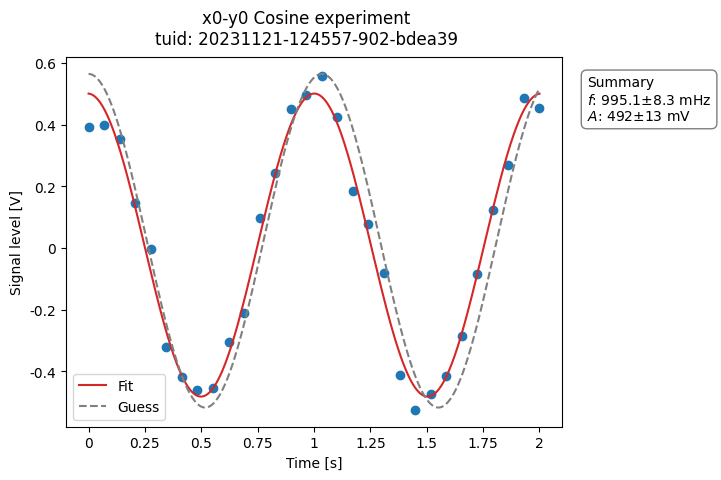

In [19]:
a_obj = CosineAnalysis(label="Cosine experiment").run()
a_obj.display_figs_mpl()

Inspecting the `experiment directory` will show something like this:

```{code-block}
20230125-172712-018-87b9bf-Cosine experiment/
├── analysis_CosineAnalysis/
│   ├── dataset_processed.hdf5
│   ├── figs_mpl/
│   │   ├── cos_fit.png
│   │   └── cos_fit.svg
│   ├── fit_results/
│   │   └── cosine.txt
│   └── quantities_of_interest.json
├── cos-data-and-fit.png
├── Cosine fit.png
├── dataset.hdf5
├── quantities_of_interest.json
└── snapshot.json
```

As you can conclude from the {class}`!CosineAnalysis` code, we did not implement quite a few methods in there.
These are provided by the {class}`~quantify_core.analysis.base_analysis.BaseAnalysis`.
To gain some insight into what exactly is being executed we can enable the logging module and use the internal logger of the analysis instance:

In [20]:
# activate logging and set global level to show warnings only
logging.basicConfig(level=logging.WARNING)

# set analysis logger level to info (the logger is inherited from BaseAnalysis)
a_obj.logger.setLevel(level=logging.INFO)
_ = a_obj.run()

INFO:CosineAnalysis:Executing `.analysis_steps` of CosineAnalysis
INFO:CosineAnalysis:extracting data: <bound method BaseAnalysis.extract_data of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x000002F45B343700>>
INFO:CosineAnalysis:executing step 1: <bound method CosineAnalysis.process_data of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x000002F45B343700>>
INFO:CosineAnalysis:executing step 2: <bound method CosineAnalysis.run_fitting of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x000002F45B343700>>
INFO:CosineAnalysis:executing step 3: <bound method CosineAnalysis.analyze_fit_results of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x000002F45B343700>>
INFO:CosineAnalysis:executing step 4: <bound method CosineAnalysis.create_figures of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x000002F45B343700>>
INFO:CosineAnalysis:executing step 5: <bound method BaseAnalysis.adjust_figures of <

INFO:CosineAnalysis:executing step 1: <bound method CosineAnalysis.process_data of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 2: <bound method CosineAnalysis.run_fitting of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 3: <bound method CosineAnalysis.analyze_fit_results of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 4: <bound method CosineAnalysis.create_figures of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 5: <bound method BaseAnalysis.adjust_figures of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 6: <bound method BaseAnalysis.save_figures of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 7: <bound method BaseAnalysis.save_quantities_of_interest of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 8: <bound method BaseAnalysis.save_processed_dataset of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>


INFO:CosineAnalysis:executing step 9: <bound method BaseAnalysis.save_fit_results of <quantify_core.analysis.cosine_analysis.CosineAnalysis object at 0x7f8629b9b7f0>>
